In [1]:
subject_name = 'Marco'

from sankar_read_vmrk_events import sankar_read_vmrk_events
import mne
import os
import numpy as np
from mne.io.brainvision import brainvision
import warnings
warnings.filterwarnings('ignore')

data_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

save_path = data_path + '/analysis/python/data/'+subject_name
raw_fname = data_path + '/exp/data/eeg_original/'+subject_name+'.vhdr'

raw = mne.io.read_raw_brainvision(raw_fname,preload=True)
#raw.set_eeg_reference('average', projection=True)  # set EEG average reference
raw.pick_types(meg=False, eeg=True, eog=True, stim=True)

raw.set_channel_types(mapping={'vEOGup': 'eog'})
raw.set_channel_types(mapping={'vEOGdown': 'eog'})
raw.set_channel_types(mapping={'LHEOG': 'eog'})
raw.set_channel_types(mapping={'RHEOG': 'eog'})
raw.rename_channels(mapping={'vEOGup': 'vEOGup'})
raw.rename_channels(mapping={'vEOGdown': 'vEOGdown'})
raw.rename_channels(mapping={'LHEOG': 'LHEOG'})
raw.rename_channels(mapping={'RHEOG': 'RHEOG'})

#events
raw_fname = data_path + '/exp/data/eeg_original/'+subject_name+'.vmrk'
events = sankar_read_vmrk_events(raw_fname)
print(raw.info)

Extracting parameters from D:\projects\current\listen_italian_motor_entrainment/exp/data/eeg_original/Marco.vhdr...
Setting channel info structure...
Currently, 1 trigger(s) will be dropped, such as [actiCAP not connected]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
Reading 0 ... 2151159  =      0.000 ...  2151.159 secs...
Currently, 1 trigger(s) will be dropped, such as [actiCAP not connected]. Consider using ``event_id`` to parse triggers that do not follow the 'S###' pattern.
<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, ...
    chs : list | 65 items (EEG: 60, EOG: 4, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 1000.

In [2]:
# for ferrara brainamp acticap
montage = mne.channels.read_montage('easycap-M1')
ch_names = montage.ch_names
remove_ch = ["Fpz", "Iz","F9", "F10", "P9", "P10", "O9", "O10", "AFz","FT9","FT10","TP9","TP10","PO9","PO10"]
a = np.nonzero(np.in1d(ch_names, remove_ch))[0]
ch_names = np.delete(ch_names,a)
montage = mne.channels.read_montage('easycap-M1',ch_names)
a=raw.set_montage(montage)

The following EEG sensors did not have a position specified in the selected montage: ['RM']. Their position has been left untouched.


In [3]:
# cut 500 + speech onset - speech offset + 500ms from the original recordings
a=np.where(events[:,2]==5)[0]
b=np.where(events[:,2]==6)[0]
a=np.sort(np.append(a,b))
selected_portion = events[a]

X=500 #500 ms
i=0
a1 =  np.array([(selected_portion[:,0][i]-X),0,100,0])
a2 = np.array([(selected_portion[:,0][i]),0,105,1])
a3 = np.array([(selected_portion[:,0][i+1]),0,106,0])
a4 = np.array([(selected_portion[:,0][i+1]+X),0,200,0])
A = np.vstack((a1,a2,a3,a4))

k=2

for i in range(2, len(selected_portion)-1,2):
    a1 =  np.array([(selected_portion[:,0][i]-X),0,100,0])
    a2 = np.array([(selected_portion[:,0][i]),0,105,k])
    a3 = np.array([(selected_portion[:,0][i+1]),0,106,0])
    a4 = np.array([(selected_portion[:,0][i+1]+X),0,200,0])
    A = np.vstack((A,a1,a2,a3,a4))
    k=k+1
    
selected_portion = A[:,0:3]

# add this events to raw and delete the original one
stim_data = np.zeros((1, len(raw.times)))
info = mne.create_info(['Trigger'], raw.info['sfreq'], ['stim'])
stim_raw = mne.io.RawArray(stim_data, info)

raw.add_channels([stim_raw], force_update_info=True)
raw.add_events(selected_portion, stim_channel='Trigger')
raw.drop_channels(['STI 014'])

info = mne.create_info(['trial_no'], raw.info['sfreq'], ['misc'])
stim_raw = mne.io.RawArray(stim_data, info)
a=A[:,[0, 1, 3]]
raw.add_channels([stim_raw], force_update_info=True)
raw.add_events(a, stim_channel='trial_no')

print(raw.info)

Creating RawArray with float64 data, n_channels=1, n_times=2151160
    Range : 0 ... 2151159 =      0.000 ...  2151.159 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=2151160
    Range : 0 ... 2151159 =      0.000 ...  2151.159 secs
Ready.
<Info | 18 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, ...
    chs : list | 66 items (EEG: 60, EOG: 4, STIM: 1, MISC: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 236 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 1000.0 Hz
    meas_date : int | 1524818526
    nchan : int | 66
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
  

In [4]:
a=mne.find_events(raw)
print(a[:10])

800 events found
Event IDs: [100 105 106 200]
[[30053     0   100]
 [30553     0   105]
 [35030     0   106]
 [35530     0   200]
 [41564     0   100]
 [42064     0   105]
 [45391     0   106]
 [45891     0   200]
 [50493     0   100]
 [50993     0   105]]


In [5]:
#cut portion of from the original recordings
X = 0.05
raw1 = raw.copy().crop(selected_portion[:,0][0]/1000 - X, selected_portion[:,0][3]/1000 + X)
for i in range(4, len(selected_portion),4):
    raw2 = raw.copy().crop(selected_portion[:,0][i]/1000 - X, selected_portion[:,0][i+3]/1000 + X)
    raw1.append([raw2])
    print(i)
    
event_id = {'Speech_onset': 105,'Speech_offset': 106}

4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
204
208
212
216
220
224
228
232
236
240
244
248
252
256
260
264
268
272
276
280
284
288
292
296
300
304
308
312
316
320
324
328
332
336
340
344
348
352
356
360
364
368
372
376
380
384
388
392
396
400
404
408
412
416
420
424
428
432
436
440
444
448
452
456
460
464
468
472
476
480
484
488
492
496
500
504
508
512
516
520
524
528
532
536
540
544
548
552
556
560
564
568
572
576
580
584
588
592
596
600
604
608
612
616
620
624
628
632
636
640
644
648
652
656
660
664
668
672
676
680
684
688
692
696
700
704
708
712
716
720
724
728
732
736
740
744
748
752
756
760
764
768
772
776
780
784
788
792
796


In [6]:
# check and remove the edge boundary annotations and make all of it continues recordings
a=mne.find_events(raw1)
print(a[:10])
raw=raw1
raw.annotations.delete(np.arange(0,raw.annotations.description.shape[0]))

800 events found
Event IDs: [100 105 106 200]
[[30053     0   100]
 [30553     0   105]
 [35030     0   106]
 [35530     0   200]
 [35631     0   100]
 [36131     0   105]
 [39458     0   106]
 [39958     0   200]
 [40059     0   100]
 [40559     0   105]]


In [7]:
#   Set up pick list: EEG + STI 014 - bad channels (modify to your needs)
include = ['Trigger']  # or stim channels ['STI 014']
raw.info['bads'] = ['RM']  
# pick eeg channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,misc=False,exclude='bads')

Effective window size : 2.048 (s)


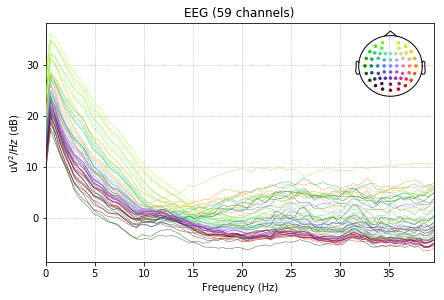

In [9]:
a=raw.plot_psd(picks=picks, tmax=np.inf, fmax=40)

In [10]:
from mne.preprocessing import ICA
# 1Hz high pass is often helpful for fitting ICA
raw.filter(1., 40., n_jobs=2, fir_design='firwin')
reject = dict(eeg=180e-6)
n_components = 25  # if float, select n_components by explained variance of PCA
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we need sufficient statistics, not all time points -> saves time
# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
a=ica.fit(raw, picks=picks, decim=decim, reject=reject)

Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 3301 samples (3.301 sec) selected


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    4.6s finished


Fitting ICA to data using 59 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
Artifact detected in [0, 667]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [667, 1334]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
Artifact detected in [2001, 2668]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
Artifact detected in [3335, 4002]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
Artifact detected in [4002, 4669]
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FC6', 'T8', 'F6', 'FC4', 'FT8', 'C6']
Artifact detected in [5336, 6003]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
Artifact detected in [9338, 10005]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [10005, 10672]
    Rejecting  epoch based on EEG : ['Fp1', '

Artifact detected in [70035, 70702]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [70702, 71369]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
Artifact detected in [71369, 72036]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
Artifact detected in [72036, 72703]
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
Artifact detected in [74037, 74704]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
Artifact detected in [74704, 75371]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [75371, 76038]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF8']
Artifact detected in [76038, 76705]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [77372, 78039]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'FC5', 'AF7']
Artifact detected in [78039, 78706]
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F3', 'F8', 'FC6', 'T8', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F6']
Artifact detected in [124062, 124729]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [124729, 125396]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'FC6', 'AF7', 'AF4', 'AF8']
Artifact detected in [125396, 126063]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [126063, 126730]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F4', 'F8', 'FC6', 'AF7', 'AF4', 'AF8', 'F6']
Artifact detected in [126730, 127397]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
Artifact detected in [127397, 128064]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [128064, 128731]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [128

Artifact detected in [169418, 170085]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'C3', 'C4', 'T8', 'CP5', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C6']
Artifact detected in [170085, 170752]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'FC5', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8', 'F6', 'FT7', 'FC3', 'FT8']
Artifact detected in [170752, 171419]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [171419, 172086]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [172086, 172753]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [172753, 173420]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [173420, 174087]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3'

Artifact detected in [212773, 213440]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
Artifact detected in [213440, 214107]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [214107, 214774]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'FC6', 'AF7', 'AF4', 'AF8']
Artifact detected in [214774, 215441]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8', 'F6', 'FT8']
Artifact detected in [215441, 216108]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [216108, 216775]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [216775, 217442]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [217442, 218109]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
Artifact detected in [218109, 218776]
    Rejecting  epoch based on EEG : ['Fp1', '

Artifact detected in [253460, 254127]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F6']
Artifact detected in [254127, 254794]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'C4', 'T8', 'CP5', 'CP6', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FC4', 'FT8', 'C5', 'C6']
Artifact detected in [254794, 255461]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC6', 'T7', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC4', 'FT8']
Artifact detected in [255461, 256128]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [256128, 256795]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [256795, 257462]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'AF7', 'AF3', 'AF4'

Artifact detected in [292813, 293480]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [293480, 294147]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [295481, 296148]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [296148, 296815]
    Rejecting  epoch based on EEG : ['Fp2']
Artifact detected in [296815, 297482]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F4', 'F8', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [297482, 298149]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [298149, 298816]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [298816, 299483]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'FC3']
Artifact detected in [29

Artifact detected in [335501, 336168]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [336168, 336835]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F8', 'AF7', 'AF3', 'AF4', 'AF8', 'F5']
Artifact detected in [336835, 337502]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F4', 'F8', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8', 'F6', 'FT8']
Artifact detected in [337502, 338169]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'FC6', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [338169, 338836]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8', 'F6']
Artifact detected in [338836, 339503]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F8', 'AF7', 'AF3', 'AF4', 'AF8']
Artifact detected in [339503, 340170]
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
Artifact detected in [340170, 340837]
    Rejecting  epoch based on EEG : ['Fp1', '

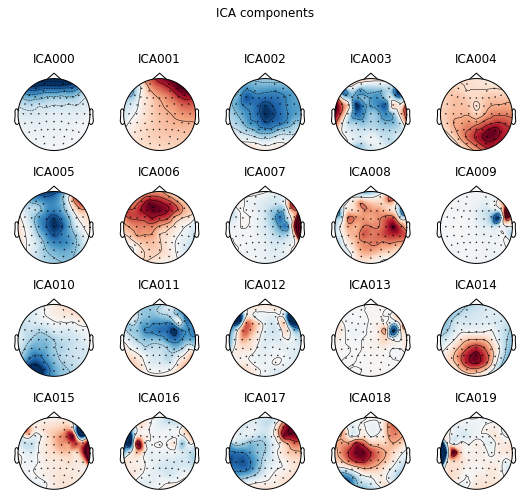

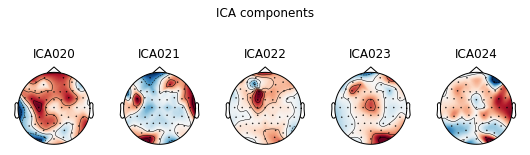

In [11]:
a=ica.plot_components()  # can you spot some potential bad guys?

    using multitaper spectrum estimation with 7 DPSS windows


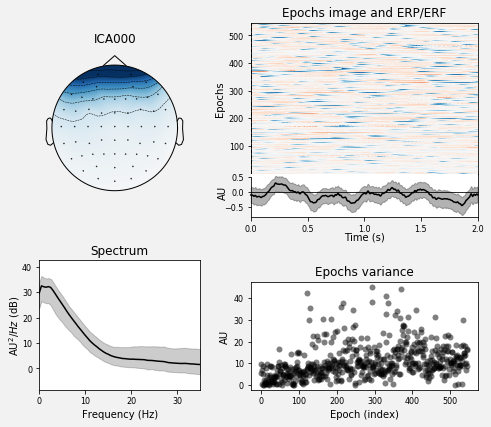

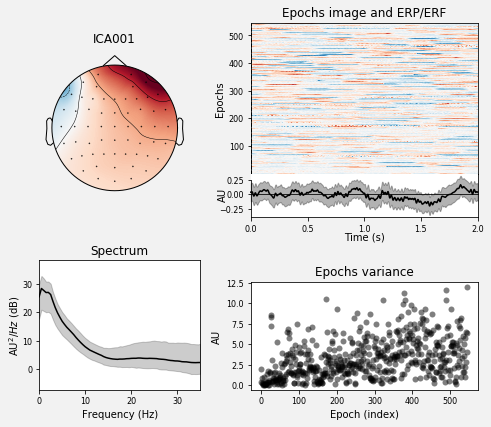

In [12]:
%matplotlib inline
eog_inds =[0,1]
a=ica.plot_properties(raw, picks=eog_inds,psd_args={'fmax': 35.})

In [13]:
#picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,include=include, exclude='bads')
#eog_average = create_eog_epochs(raw, reject=reject,picks=picks).average()
#ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
# red -> before, black -> after. Yes! We remove quite a lot!

# to definitely register this component as a bad one to be removed
# there is the ``ica.exclude`` attribute, a simple Python list
ica.exclude.extend(eog_inds)

# from now on the ICA will reject this component even if no exclude
# parameter is passed, and this information will be stored to disk
# on saving

# uncomment this for reading and writing
ica.save(save_path +'-ica.fif')
# ica = read_ica('my-ica.fif')

Writing ICA solution to D:\projects\current\listen_italian_motor_entrainment/analysis/python/data/Marco-ica.fif...


<ICA  |  raw data decomposition, fit (fastica): 30682 samples, 25 components, channels used: "eeg", 2 sources marked for exclusion>

Transforming to ICA space (25 components)
Zeroing out 2 ICA components


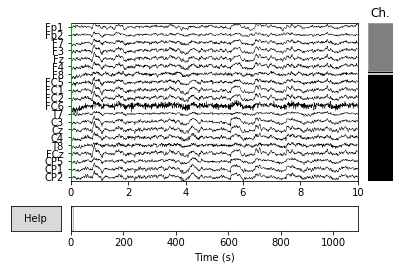

In [14]:
ica.apply(raw)
a=raw.plot()  # check the result

In [15]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=True, eog=False, misc=True,exclude='bads')
raw.save(save_path +'_raw.fif',picks=picks,overwrite=True)

Writing D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\Marco_raw.fif
Closing D:\projects\current\listen_italian_motor_entrainment\analysis\python\data\Marco_raw.fif [done]
